# Install packages

In [ ]:
!pip install pydicom
!pip install ffmpeg
!pip install elasticdeform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=89dab65894e028a8aa998d3aa5931d245bf33c5fba78844727dc51e270ad99a2
  Stored in directory: /root/.cache/pip/wheels/56/30/c5/576bdd729f3bc062d62a551be7fefd6ed2f761901568171e4e
Successfully built ffmpeg
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.6 MB/s eta 0:00:00


# Import packages

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
import os
import random
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
import skimage as ski
from skimage import io, transform
import pydicom as dicom
import shutil
import glob
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
import pandas as pd
import seaborn as sns

# Mount Drive

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
path = "/content/gdrive/MyDrive/IBEC"
os.chdir(path)

Mounted at /content/gdrive


# Import .py

In [ ]:
from data import trainGenerator_seg, predictGenerator_seg, postprocess, saveResult_seg, readreshape
from model import unet_rois, unet_seg, pixelwise_weighted_binary_crossentropy_seg, unstack_acc
import config as cfg
import utilities as utils

# Convert input data from .dcm to .png

In [ ]:
# inputdir = 'Images/Image_set/'
# outputdir = 'Images/Image_set_png/'

# test_list = [f for f in  os.listdir(inputdir)]
# print(len(os.listdir(inputdir)))
# print(len(os.listdir(outputdir)))

# min_x = np.inf
# min_y = np.inf
# for f in test_list:
#    if f.replace(".dcm", ".png") not in os.listdir(outputdir):
#      ds = dicom.dcmread(inputdir + f) # read dicom image
#      img = ds.pixel_array # get image array
#      try:
#        plt.imsave(outputdir + f.replace(".dcm", ".png"), img, cmap="gray")
#      except Exception as e:
#        ch, x, y = img.shape
#        for i in range(ch):
#          plt.imsave(outputdir + f.replace(".dcm", f"({i}).png"), img[i,:,:], cmap="gray")



In [ ]:
# print(len(os.listdir(inputdir)))
# print(len(os.listdir(outputdir)))

In [ ]:
mask_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Masks"
mask_files = os.listdir(mask_path)

for f in mask_files:
  # img = io.imread(mask_path + "//" + f)
  # img = ski.color.gray2rgb(img)
  # img = img.squeeze()
  # print(mask_path + "//" + f)
  img = io.imread(mask_path + "//" + f)[:,:,:3]
  # img = ski.color.rgb2gray(img).astype(np.uint8)
  plt.imsave(mask_path + "//" + f, img)

In [ ]:
for f in mask_files:
  img = io.imread(mask_path + "//" + f)
  print(img.shape)

# Creating Validation set


In [ ]:
img_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Original"  # Path with all the images (or with the training images)
validation_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Validation"  # Path to save the validation images

img_files = os.listdir(img_path)
val_files = os.listdir(validation_path)

# Si hay imágenes en validation_path:
# Si están en Original, se eliminan de validation_path
# Si no, se mueven de validation_path a img_path
if val_files:
  for f in val_files:
    if f in img_files:
      os.remove(validation_path + "//" + f)  # Remove if in Original
    else:
      shutil.move(validation_path + "//" + f, img_path)  # Move back to Original

print(len(os.listdir(img_path)))
print(len(os.listdir(validation_path)))

# Seleccionar aleatoriamente imágenes para validación
validation = 9
new_validation_set = np.random.choice(img_files, validation, replace=False) # replace=False to avoid duplicates
print(new_validation_set)

# Mover las imágenes de Original a Validation, skipping existing files
for f in new_validation_set:
  destination_path = os.path.join(validation_path, f) # Create destination path
  if not os.path.exists(destination_path): # Check if file exists in destination
    shutil.move(os.path.join(img_path, f), validation_path) # Move only if it doesn't exist
  else:
    print(f"File '{f}' already exists in validation set, skipping.")



# Training

## Parameters for training

In [ ]:
# Parameters:
batch_size = 64
epochs = 30
steps_per_epoch = 1000
patience = 5

#Data generator parameters:
data_gen_args = dict(
    rotation = 1,
    rotations_90d = True,
    zoom=.05,
    horizontal_flip=True,
    vertical_flip=True,
    illumination_voodoo=True,
    gaussian_noise = 0.01,
    gaussian_blur = 0.01
    )

# Paths
img_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Original"
validation_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Validation"
mask_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Masks"
savefile = "/content/gdrive/MyDrive/IBEC/unet_agarpads_seg_optimized.hdf5.keras"
no_val = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/No_val"
no_fat = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/No_fat"
overfitting = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/overfitting"

## Generator for training the segmentation U-Net

In [ ]:
myGene = trainGenerator_seg(
    batch_size=batch_size,
    img_path=img_path,
    mask_path=mask_path,
    weight_path=mask_path,
    target_size=cfg.target_size_seg,
    augment_params=data_gen_args,
    crop_windows=cfg.crop_windows
    )
validationGene = trainGenerator_seg(
    batch_size=batch_size,
    img_path=validation_path,
    mask_path=mask_path,
    weight_path=mask_path,
    target_size=cfg.target_size_seg,
    augment_params=data_gen_args,
    crop_windows=cfg.crop_windows
    )
myGene_noval = trainGenerator_seg(
    batch_size=batch_size,
    img_path=no_val,
    mask_path=mask_path,
    weight_path=mask_path,
    target_size=cfg.target_size_seg,
    augment_params=data_gen_args,
    crop_windows=cfg.crop_windows
    )
myGene_nofat = trainGenerator_seg(
    batch_size=batch_size,
    img_path=no_fat,
    mask_path=mask_path,
    weight_path=mask_path,
    target_size=cfg.target_size_seg,
    augment_params=data_gen_args
    )
myGene_overfitting = trainGenerator_seg(
    batch_size=batch_size,
    img_path=overfitting,
    mask_path=mask_path,
    weight_path=mask_path,
    target_size=cfg.target_size_seg,
    # augment_params=data_gen_args,
    crop_windows=cfg.crop_windows
    )

## Initialization of model

In [ ]:
print(cfg.target_size_seg+(1,))  # Target size for cropped images

In [ ]:
def iou_metric(y_true, y_pred):
    y_true = y_true[:,:,:,0]
    y_pred = y_pred[:,:,:,0]
    y_pred = tf.cast(y_pred > 0.5, tf.bool)  # Umbral para binarizar la predicción
    y_true = tf.cast(y_true, tf.bool)

    intersection = tf.cast(tf.math.logical_and(y_true, y_pred), tf.float32)
    union = tf.cast(tf.math.logical_or(y_true, y_pred), tf.float32)

    iou = tf.reduce_sum(intersection)/(tf.reduce_sum(union))

    return iou


In [ ]:
# Load model
model = unet_seg(input_size=cfg.target_size_seg+(1,),
                #  beta_1=0.85, beta_2=0.98,
                #  amsgrad=True,
                learning_rate=1e-4,
                # loss="Dice",
                metrics=[unstack_acc, iou_metric]
                 )
# model.summary()

In [ ]:
model.load_weights("/content/gdrive/MyDrive/IBEC/Models/unet_agarpads_seg_optimized.hdf5")


## Callbacks

In [ ]:
# Callback to save the model every N epochs
class SaveEveryNEpochs(tf.keras.callbacks.Callback):
    def __init__(self, filepath, save_every=5):
        super(SaveEveryNEpochs, self).__init__()
        self.filepath = filepath
        self.save_every = save_every

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_every == 0:  # Guardar cada N épocas
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            self.model.save_weights(filepath)
            print(f"\nModelo guardado: {filepath}")

In [ ]:
# Schedulers to reduce learning rate
def scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.5))

scheduler_callback = keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
def scheduler(epoch, lr, t1, t2, max_lr, alpha):
    if epoch <= t1:
        return max_lr*0.5*(1-np.cos(np.pi*epoch/t1))
    else:
        return max_lr*(0.5*(1-np.cos(np.pi*(epoch-t1-t2)/t2))*(1-alpha)+alpha)

scheduler_callback = keras.callbacks.LearningRateScheduler(
    lambda epoch, lr: scheduler(epoch, lr, t1=5, t2=65, max_lr=0.01, alpha=0.0001))

In [ ]:
savefile = "/content/gdrive/MyDrive/IBEC/Models/10th training/modelo_epoca_{epoch:02d}.weights.h5"
# model_checkpoint = keras.callbacks.ModelCheckpoint(
#     savefile, monitor='loss', verbose=1, save_best_only=False,
#     save_weights_only=True, save_freq=5
#     )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss', mode='min', verbose=1, patience=patience
    )
save_callback = SaveEveryNEpochs(filepath=savefile, save_every=15)

## Training

In [ ]:
print(os.listdir(overfitting), len(os.listdir(overfitting)))
print(os.listdir(no_val), len(os.listdir(no_val)))
print(os.listdir(img_path), len(os.listdir(img_path)))
print(os.listdir(mask_path), len(os.listdir(mask_path)))
print(os.listdir(validation_path), len(os.listdir(validation_path)))

In [ ]:
history = model.fit(
    myGene,
    steps_per_epoch=300,
    epochs=15,
    # callbacks=[save_callback, early_stopping],
    # callbacks=scheduler_callback,
    validation_data=validationGene,
    validation_steps=1,
    verbose=1
    )

# Training with cross-validation

## Function to create training and validation sets from original image set with all data

In [ ]:
def move_files_validation(train_files, val_files, train_path, val_path,
                          original_path):
    train_files_ini = os.listdir(train_path)
    val_files_ini = os.listdir(val_path)

    # Erase existing images in destination folders
    if train_files_ini:
        for f in train_files_ini:
            os.remove(train_path + "//" + f)
    if val_files_ini:
        for f in val_files_ini:
            os.remove(val_path + "//" + f)

    # Copy files to destination folders
    for f in train_files:
        shutil.copy(original_path + "//" + f, train_path)
    for f in val_files:
        shutil.copy(original_path + "//" + f, val_path)


In [ ]:
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_iou_metric',
#                                               factor=0.25,
#                                               patience=2)

In [ ]:
savefile = "/content/gdrive/MyDrive/IBEC/Models/51st training/Checkpoints/checkpoint.weights.h5"
model_checkpoint = keras.callbacks.ModelCheckpoint(
     savefile, verbose=0, save_best_only=False,
     save_weights_only=True
     )

## Metrics and losses

In [ ]:
def iou_metric(y_true, y_pred):
    y_true = y_true[:,:,:,0]
    y_pred = y_pred[:,:,:,0]
    y_pred = tf.cast(y_pred > 0.5, tf.bool)  # Umbral para binarizar la predicción
    y_true = tf.cast(y_true, tf.bool)

    intersection = tf.cast(tf.math.logical_and(y_true, y_pred), tf.float32)
    union = tf.cast(tf.math.logical_or(y_true, y_pred), tf.float32)

    iou = tf.reduce_sum(intersection)/(tf.reduce_sum(union))

    return iou

In [ ]:
def F1_metric(y_true, y_pred):
    y_true = y_true[:,:,:,0]
    y_pred = y_pred[:,:,:,0]
    y_pred = tf.cast(y_pred > 0.5, tf.bool)  # Umbral para binarizar la predicción
    y_true = tf.cast(y_true, tf.bool)

    intersection = tf.cast(tf.math.logical_and(y_true, y_pred), tf.float32)
    union = tf.cast(tf.math.logical_or(y_true, y_pred), tf.float32)

    f1 = 2*tf.reduce_sum(intersection)/(tf.reduce_sum(union) + tf.reduce_sum(intersection))

    return f1

In [ ]:
def BCE_loss(y_true, y_pred, epsilon=1e-7):
    y_true = y_true[:,:,:,0]
    y_pred = y_pred[:,:,:,0]
    y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)  # To avoid log(0)

    bce = y_true*tf.math.log(y_pred) + (1-y_true)*tf.math.log(1-y_pred)
    loss = -tf.reduce_mean(bce)

    return loss

my_BCE_loss = lambda y_true, y_pred: BCE_loss(y_true, y_pred)

In [ ]:
def PWBCE_loss(y_true, y_pred, epsilon=1e-7):
    y_true = y_true[:,:,:,0]
    y_pred = y_pred[:,:,:,0]
    y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)  # To avoid log(0)

    cond = y_true == 0  # 1 if background; 0 if not
    weights = tf.where(cond, y_pred, y_true)  # y_pred if background; 1 if not

    pwce = weights*(y_true*tf.math.log(y_pred) + (1-y_true)*tf.math.log(1-y_pred))
    loss = -tf.reduce_mean(pwce)

    return loss

my_PWBCE_loss = lambda y_true, y_pred: PWBCE_loss(y_true, y_pred)

In [ ]:
def FL_loss(y_true, y_pred, alpha, gamma, epsilon=1e-7):
    y_true = y_true[:,:,:,0]
    y_pred = y_pred[:,:,:,0]
    y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)  # To avoid log(0)


    fl = alpha*(1-y_pred)**gamma*y_true*tf.math.log(y_pred) + (1-alpha)*y_pred**gamma*(1-y_true)*tf.math.log(1-y_pred)
    loss = -tf.reduce_mean(fl)

    return loss

In [ ]:
def IoU_loss(y_true, y_pred, epsilon=1e-7):
    y_true = y_true[:,:,:,0]
    y_pred = y_pred[:,:,:,0]

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred - intersection)

    iou = (intersection + epsilon)/(union + epsilon)  # To avoid division by 0
    loss = 1-iou

    return loss

my_IoU_loss = lambda y_true, y_pred: IoU_loss(y_true, y_pred)

In [ ]:
def dice_loss(y_true, y_pred, epsilon=1e-7):
    y_true = y_true[:,:,:,0]
    y_pred = y_pred[:,:,:,0]

    intersection = tf.reduce_sum(y_true * y_pred)
    a = tf.reduce_sum(y_true)
    b = tf.reduce_sum(y_pred)

    dice = (2*intersection + epsilon) / (a + b + epsilon)  # To avoid division by 0
    loss = 1 - dice

    return loss

my_dice_loss = lambda y_true, y_pred: dice_loss(y_true, y_pred)

In [ ]:
def MLF_loss(y_true, y_pred, epsilon=1e-7):
    return PWBCE_loss(y_true, y_pred, epsilon) + dice_loss(y_true, y_pred, epsilon) + FL_loss(y_true, y_pred, alpha=0.5, gamma=1)

my_MLF_loss = lambda y_true, y_pred: MLF_loss(y_true, y_pred)

## Training settings

In [ ]:
# Define the number of folds for cross-validation and training settings
n_splits = 5
batch_size = 128
steps_per_epoch = 300
epochs = 8

# Data augmentation args
# data_gen_args = dict(
#     rotation = 20,
#     # rotations90d = True,
#     rotations90d = False,
#     zoom=.04,
#     # horizontal_flip=True,
#     horizontal_flip=False,
#     # vertical_flip=True,
#     vertical_flip=False,
#     # illumination_voodoo=True,
#     # histogram_voodoo=True,
#     gaussian_noise = 0.05,
#     # gaussian_noise = 0.1,
#     # shiftX=10,
#     shiftX=5,
#     # shiftY=10
#     shiftY=5
#     )

data_gen_args = dict(
    rotation = 2,
    rotations_90d = True,
    zoom=.15,
    horizontal_flip=True,
    vertical_flip=True,
    illumination_voodoo=True,
    gaussian_noise = 0.03,
    )

no_val = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/No_val"
img_files = os.listdir(no_val)
train_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Original"
validation_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Validation"
mask_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Masks"

## Initializations

In [ ]:
# Create a KFold object
kf = KFold(n_splits=n_splits, shuffle=True)
folds = list(kf.split(img_files))

# Save folds (for not training in a row)
with open("/content/gdrive/MyDrive/IBEC/temp/folds.pkl", 'wb') as file:
    pickle.dump(folds, file)

In [ ]:
# Initialize metrics dictionary
metrics = {}
# Save (for not training in a row)
with open("/content/gdrive/MyDrive/IBEC/temp/metrics.pkl", 'wb') as file:
    pickle.dump(metrics, file)

## All trainings in a row

In [ ]:
metrics = {}

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(img_files)):
    print(f"Training Fold {fold + 1}/{n_splits}")

    print("Generating training and validation folders...")
    # Split data into training and validation sets for this fold
    train_files = [img_files[i] for i in train_index]
    val_files = [img_files[i] for i in val_index]

    # Change directory of images:
    # train_files -> Original
    # val_files -> Validation
    move_files_validation(train_files, val_files, train_path, validation_path,
                          no_val)
    print("Path generation complete.")
    print("-"*30)

    # Create data generators for this fold
    train_generator = trainGenerator_seg(
        batch_size=batch_size,
        img_path=train_path,
        mask_path=mask_path,
        weight_path=mask_path,
        target_size=cfg.target_size_seg,
        augment_params=data_gen_args,
        crop_windows=cfg.crop_windows,
    )

    validation_generator = trainGenerator_seg(
        batch_size=batch_size,
        img_path=validation_path,
        mask_path=mask_path,
        weight_path=mask_path,
        target_size=cfg.target_size_seg,
        crop_windows=cfg.crop_windows,
    )

    # Reinitialize the model for each fold to avoid weight carry-over
    model = unet_seg(input_size=cfg.target_size_seg+(1,), learning_rate=1e-4,
                     metrics=[unstack_acc, iou_metric])
    model.load_weights("/content/gdrive/MyDrive/IBEC/Models/unet_agarpads_seg_optimized.hdf5")

    # Train the model on the current fold
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        # callbacks=[reduce_lr],
        validation_data=validation_generator,
        validation_steps=1,  # Adjust steps based on validation set size
        verbose=1
    )

    metrics[fold+1] = {"train loss": history.history["loss"][-1],
                       "val loss": history.history["val_loss"][-1],
                       "train unstack_acc": history.history["unstack_acc"][-1],
                       "val unstack_acc": history.history["val_unstack_acc"][-1],
                       "train IoU": history.history["iou_metric"][-1],
                       "val IoU": history.history["val_iou_metric"][-1],
                       }

    savemodel_path = "/content/gdrive/MyDrive/IBEC/Models/39th training"
    savehistory_path = "/content/gdrive/MyDrive/IBEC/Training_results/39th training"

    # Save the model weights and history for the current fold
    model.save_weights(savemodel_path + f"/unet_fold_{fold + 1}.weights.h5")
    with open(savehistory_path + f"/history_fold_{fold + 1}.pkl", 'wb') as file:
        pickle.dump(history.history, file)

# Save the results of the 5 trainings
df_metrics = pd.DataFrame(metrics).T
df_metrics.to_csv(savehistory_path + "/metrics.csv")
df_metrics


Training Fold 1/5
Generating training and validation folders...
Path generation complete.
------------------------------
Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2533s 3s/step - iou_metric: 0.1221 - loss: 468.5695 - unstack_acc: 0.8966 - val_iou_metric: 0.3936 - val_loss: 366.0780 - val_unstack_acc: 0.8626
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2481s 2s/step - iou_metric: 0.2817 - loss: 284.9822 - unstack_acc: 0.9061 - val_iou_metric: 0.3632 - val_loss: 369.1251 - val_unstack_acc: 0.8577
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2542s 3s/step - iou_metric: 0.2884 - loss: 291.7740 - unstack_acc: 0.9021 - val_iou_metric: 0.4902 - val_loss: 329.0131 - val_unstack_acc: 0.8811
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2542s 3s/step - iou_metric: 0.2790 - loss: 292.3561 - unstack_acc: 0.9026 - val_iou_metric: 0.5034 - val_loss: 334.7886 - val_unstack_acc: 0.8839
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2482s 2s/step - iou_metric: 0.2795 - loss: 295.0466 - unstack_acc: 0.9031 - val_iou_metric

## Trainings with breaks

In [ ]:
fold = 4

# alpha = 0.5  # alpha = [0.25, 0.5, 0.75]
# gamma = 3  # gamma = [1, 2, 3]
# my_FL_loss = lambda y_true, y_pred: FL_loss(y_true, y_pred, alpha, gamma)


# Load folds
with open("/content/gdrive/MyDrive/IBEC/temp/folds.pkl", 'rb') as file:
    folds = pickle.load(file)

# Get fold
train_index, val_index = folds[fold-1]

print(f"Training Fold {fold}/{n_splits}")
print("Generating training and validation folders...")
# Split data into training and validation sets for this fold
train_files = [img_files[i] for i in train_index]
val_files = [img_files[i] for i in val_index]

# Change directory of images:
# train_files -> Original
# val_files -> Validation
move_files_validation(train_files, val_files, train_path, validation_path,
                      no_val)
print("Path generation complete.")
print("-"*30)

# Create data generators for this fold
train_generator = trainGenerator_seg(
    batch_size=batch_size,
    img_path=train_path,
    mask_path=mask_path,
    weight_path=mask_path,
    target_size=cfg.target_size_seg,
    augment_params=data_gen_args,
    crop_windows=cfg.crop_windows,
)

validation_generator = trainGenerator_seg(
    batch_size=batch_size,
    img_path=validation_path,
    mask_path=mask_path,
    weight_path=mask_path,
    target_size=cfg.target_size_seg,
    crop_windows=cfg.crop_windows,
)

# Reinitialize the model for each fold to avoid weight carry-over
model = unet_seg(input_size=cfg.target_size_seg+(1,), learning_rate=1e-4,
                 loss=my_MLF_loss,
                 metrics=[unstack_acc, iou_metric, F1_metric])
# model.load_weights("/content/gdrive/MyDrive/IBEC/Models/unet_agarpads_seg_optimized.hdf5")
model.load_weights("/content/gdrive/MyDrive/IBEC/Models/51st training/Checkpoints/checkpoint.weights.h5")

# Train the model on the current fold
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    # epochs=15,
    # callbacks=[reduce_lr],
    callbacks=[model_checkpoint],
    validation_data=validation_generator,
    validation_steps=1,  # Adjust steps based on validation set size
    verbose=1
    )

# # Load metrics
# with open("/content/gdrive/MyDrive/IBEC/temp/metrics.pkl", 'rb') as file:
#     metrics = pickle.load(file)

# name = f"alpha={alpha}; gamma={gamma}"
# metrics[name] = {"train loss": history.history["loss"][-1],
#                  "val loss": history.history["val_loss"][-1],
#                  "train unstack_acc": history.history["unstack_acc"][-1],
#                  "val unstack_acc": history.history["val_unstack_acc"][-1],
#                  "train IoU": history.history["iou_metric"][-1],
#                  "val IoU": history.history["val_iou_metric"][-1],
#                  "train F1": history.history["f1_metric"][-1],
#                  "val F1": history.history["val_f1_metric"][-1]
#                  }

# # Save metrics
# with open("/content/gdrive/MyDrive/IBEC/temp/metrics.pkl", 'wb') as file:
#     pickle.dump(metrics, file)


savemodel_path = "/content/gdrive/MyDrive/IBEC/Models/51st training"
savehistory_path = "/content/gdrive/MyDrive/IBEC/Training_results/51st training"

# Save the model weights and history for the current fold
model.save_weights(savemodel_path + f"/unet_fold_{fold}.weights.h5")
with open(savehistory_path + f"/history_fold_{fold}.pkl", 'wb') as file:
    pickle.dump(history.history, file)

Training Fold 4/5
Generating training and validation folders...
Path generation complete.
------------------------------


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 1344s 4s/step - f1_metric: 0.7579 - iou_metric: 0.6107 - loss: 0.5120 - unstack_acc: 0.9218 - val_f1_metric: 0.7888 - val_iou_metric: 0.6513 - val_loss: 0.4997 - val_unstack_acc: 0.9165
Epoch 2/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 1275s 4s/step - f1_metric: 0.7728 - iou_metric: 0.6302 - loss: 0.4855 - unstack_acc: 0.9261 - val_f1_metric: 0.7899 - val_iou_metric: 0.6528 - val_loss: 0.5048 - val_unstack_acc: 0.9143
Epoch 3/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 1282s 4s/step - f1_metric: 0.7848 - iou_metric: 0.6462 - loss: 0.4671 - unstack_acc: 0.9286 - val_f1_metric: 0.7982 - val_iou_metric: 0.6642 - val_loss: 0.4798 - val_unstack_acc: 0.9189
Epoch 4/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 1224s 4s/step - f1_metric: 0.7883 - iou_metric: 0.6511 - loss: 0.4539 - unstack_acc: 0.9320 - val_f1_metric: 0.8027 - val_iou_metric: 0.6705 - val_loss: 0.4599 - val_unstack_acc: 0.9192
Epoch 5/8
300/300 ━━━━━━━━━━━━━━━━━━━━ 1280s 4s/step - f1_metric: 0.8006 - iou_metric: 0.6679 - loss

## Save last values metrics in .csv

In [ ]:
savehistory_path = "/content/gdrive/MyDrive/IBEC/Training_results/48th training"
with open("/content/gdrive/MyDrive/IBEC/temp/metrics.pkl", 'rb') as file:
    metrics = pickle.load(file)

df_metrics = pd.DataFrame(metrics).T
df_metrics.to_csv(savehistory_path + "/metrics.csv")
df_metrics

,train loss,val loss,train unstack_acc,val unstack_acc,train IoU,val IoU,train F1,val F1
alpha=0.25; gamma=2,0.021737,0.021898,0.897581,0.912241,0.397251,0.579919,0.551635,0.734113
alpha=0.5; gamma=2,0.021828,0.022894,0.927967,0.924934,0.621586,0.664364,0.766311,0.798340
alpha=0.75; gamma=2,0.026900,0.020640,0.895932,0.906359,0.572735,0.641844,0.722825,0.781857
alpha=0.5; gamma=1,0.042025,0.041069,0.928794,0.931259,0.623222,0.672143,0.767514,0.803930
alpha=0.5; gamma=3,0.016763,0.011953,0.891846,0.929621,0.447362,0.655414,0.617011,0.791843


## Plots

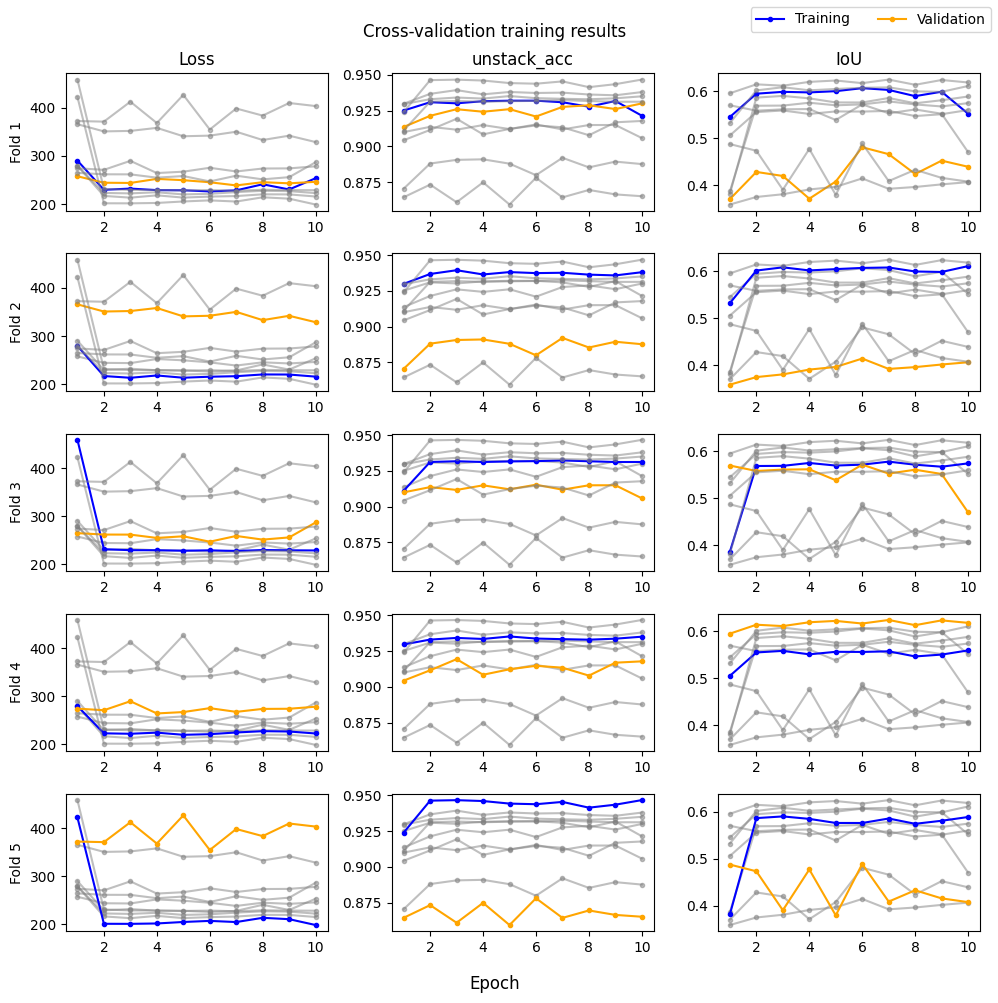

In [ ]:
with open("/content/gdrive/MyDrive/IBEC/Training_results/39th training/history_fold_1.pkl", "rb") as file:
    history_1 = pickle.load(file)
with open("/content/gdrive/MyDrive/IBEC/Training_results/39th training/history_fold_2.pkl", "rb") as file:
    history_2 = pickle.load(file)
with open("/content/gdrive/MyDrive/IBEC/Training_results/39th training/history_fold_3.pkl", "rb") as file:
    history_3 = pickle.load(file)
with open("/content/gdrive/MyDrive/IBEC/Training_results/39th training/history_fold_4.pkl", "rb") as file:
    history_4 = pickle.load(file)
with open("/content/gdrive/MyDrive/IBEC/Training_results/39th training/history_fold_5.pkl", "rb") as file:
    history_5 = pickle.load(file)

history = {1: history_1, 2: history_2, 3: history_3, 4: history_4, 5: history_5}

fig, axs = plt.subplots(5, 3, figsize=(10,10))
for i in range(5):
    plt.subplot(5, 3, 3*i+1)
    for j in range(1,6):
        if j != i+1:
            plt.plot(range(1,11), history[j]["loss"], color="gray", marker=".", alpha=0.5)
            plt.plot(range(1,11), history[j]["val_loss"], color="gray", marker=".", alpha=0.5)
        else:
            plt.plot(range(1,11), history[j]["loss"], color="blue", marker=".")
            plt.plot(range(1,11), history[j]["val_loss"], color="orange", marker=".")

    plt.ylabel(f"Fold {i+1}")
    if i == 0:
      plt.title("Loss")

    plt.subplot(5, 3, 3*i+2)
    for j in range(1,6):
        if j != i+1:
            plt.plot(range(1,11), history[j]["unstack_acc"], color="gray", marker=".", alpha=0.5)
            plt.plot(range(1,11), history[j]["val_unstack_acc"], color="gray", marker=".", alpha=0.5)
        else:
            plt.plot(range(1,11), history[j]["unstack_acc"], color="blue", marker=".")
            plt.plot(range(1,11), history[j]["val_unstack_acc"], color="orange", marker=".")

    if i == 0:
      plt.title("unstack_acc")

    plt.subplot(5, 3, 3*i+3)
    for j in range(1,6):
        if j != i+1:
            plt.plot(range(1,11), history[j]["iou_metric"], color="gray", marker=".", alpha=0.5)
            plt.plot(range(1,11), history[j]["val_iou_metric"], color="gray", marker=".", alpha=0.5)
        elif i==0:
            plt.plot(range(1,11), history[j]["iou_metric"], color="blue", marker=".", label="Training")
            plt.plot(range(1,11), history[j]["val_iou_metric"], color="orange", marker=".", label="Validation")
        else:
            plt.plot(range(1,11), history[j]["iou_metric"], color="blue", marker=".")
            plt.plot(range(1,11), history[j]["val_iou_metric"], color="orange", marker=".")

    if i == 0:
      plt.title("IoU")

fig.supxlabel("Epoch")
plt.suptitle("Cross-validation training results")
fig.legend(ncol=2)
plt.tight_layout()

plt.savefig("/content/gdrive/MyDrive/IBEC/Training_results/39th training/cross-validation.png", dpi=600)

,train loss,val loss,train unstack_acc,val unstack_acc,train IoU,val IoU
Fold,,,,,,
1,253.482391,246.027847,0.921451,0.930054,0.551834,0.439009
2,215.498703,328.639221,0.937991,0.887629,0.610817,0.406347
3,228.620361,286.735931,0.931234,0.905836,0.574410,0.470182
4,222.576904,278.226135,0.935034,0.917789,0.559683,0.618286
5,198.848831,403.450714,0.946734,0.865137,0.588463,0.407417


<ipython-input-154-619524b14ccc>:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


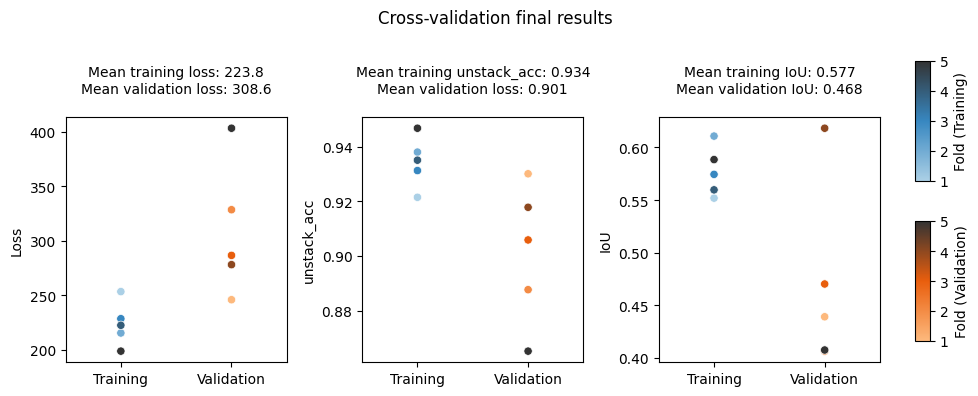

In [ ]:
df_metrics = pd.read_csv("/content/gdrive/MyDrive/IBEC/Training_results/39th training/metrics.csv", index_col=0)
df_metrics.index.name = "Fold"
display(df_metrics)

fig, axes = plt.subplots(1, 3, figsize=(10, 4))  # Espacio para barras de color

# Crear colormaps para Training y Validation
cmap_train = sns.color_palette("Blues_d", as_cmap=True)
cmap_val = sns.color_palette("Oranges_d", as_cmap=True)

# Primer subplot: Loss
ax = axes[0]
x_train = np.full_like(df_metrics["train loss"], 0)
x_val = np.full_like(df_metrics["val loss"], 2)
sns.scatterplot(x=x_train, y=df_metrics["train loss"], hue=df_metrics.index, palette=cmap_train, legend=False, ax=ax)
sns.scatterplot(x=x_val, y=df_metrics["val loss"], hue=df_metrics.index, palette=cmap_val, legend=False, ax=ax)
ax.set_xlim([-1, 3])
ax.set_xticks([0, 2])
ax.set_xticklabels(["Training", "Validation"])
ax.set_ylabel("Loss")
ax.set_title(f"""
Mean training loss: {df_metrics['train loss'].mean():.1f}
Mean validation loss: {df_metrics['val loss'].mean():.1f}
             """, fontsize="medium")

# Segundo subplot: Unstack Accuracy
ax = axes[1]
x_train = np.full_like(df_metrics["train unstack_acc"], 0)
x_val = np.full_like(df_metrics["val unstack_acc"], 2)
sns.scatterplot(x=x_train, y=df_metrics["train unstack_acc"], hue=df_metrics.index, palette=cmap_train, legend=False, ax=ax)
sns.scatterplot(x=x_val, y=df_metrics["val unstack_acc"], hue=df_metrics.index, palette=cmap_val, legend=False, ax=ax)
ax.set_xlim([-1, 3])
ax.set_xticks([0, 2])
ax.set_xticklabels(["Training", "Validation"])
ax.set_ylabel("unstack_acc")
ax.set_title(f"""
Mean training unstack_acc: {df_metrics['train unstack_acc'].mean():.3f}
Mean validation loss: {df_metrics['val unstack_acc'].mean():.3f}
             """, fontsize="medium")

# Tercer subplot: IoU
ax = axes[2]
x_train = np.full_like(df_metrics["train IoU"], 0)
x_val = np.full_like(df_metrics["val IoU"], 2)
sns.scatterplot(x=x_train, y=df_metrics["train IoU"], hue=df_metrics.index, palette=cmap_train, legend=False, ax=ax)
sns.scatterplot(x=x_val, y=df_metrics["val IoU"], hue=df_metrics.index, palette=cmap_val, legend=False, ax=ax)
ax.set_xlim([-1, 3])
ax.set_xticks([0, 2])
ax.set_xticklabels(["Training", "Validation"])
ax.set_ylabel("IoU")
ax.set_title(f"""
Mean training IoU: {df_metrics['train IoU'].mean():.3f}
Mean validation IoU: {df_metrics['val IoU'].mean():.3f}
             """, fontsize="medium")

# Agregar barras de color
cax_train = fig.add_axes([0.92, 0.55, 0.015, 0.3])  # Posición de la barra de color
cax_val = fig.add_axes([0.92, 0.15, 0.015, 0.3])  # Segunda barra

norm = mcolors.Normalize(vmin=df_metrics.index.min(), vmax=df_metrics.index.max())  # Normalizar índice de época
cb1 = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap_train), cax=cax_train)
cb1.set_label("Fold (Training)")
cb1.ax.get_yaxis().set_ticks_position('right')  # Keep only the right ticks
cb1.ax.tick_params(axis='y', left=False, bottom=False)  # Remove left and bottom ticks/lines

cb2 = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap_val), cax=cax_val)
cb2.set_label("Fold (Validation)")
cb2.ax.get_yaxis().set_ticks_position('right')  # Keep only the right ticks
cb2.ax.tick_params(axis='y', left=False, bottom=False)  # Remove left and bottom ticks/lines

plt.suptitle("Cross-validation final results")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig("/content/gdrive/MyDrive/IBEC/Training_results/39th training/final-cross-validation.png", dpi=600)

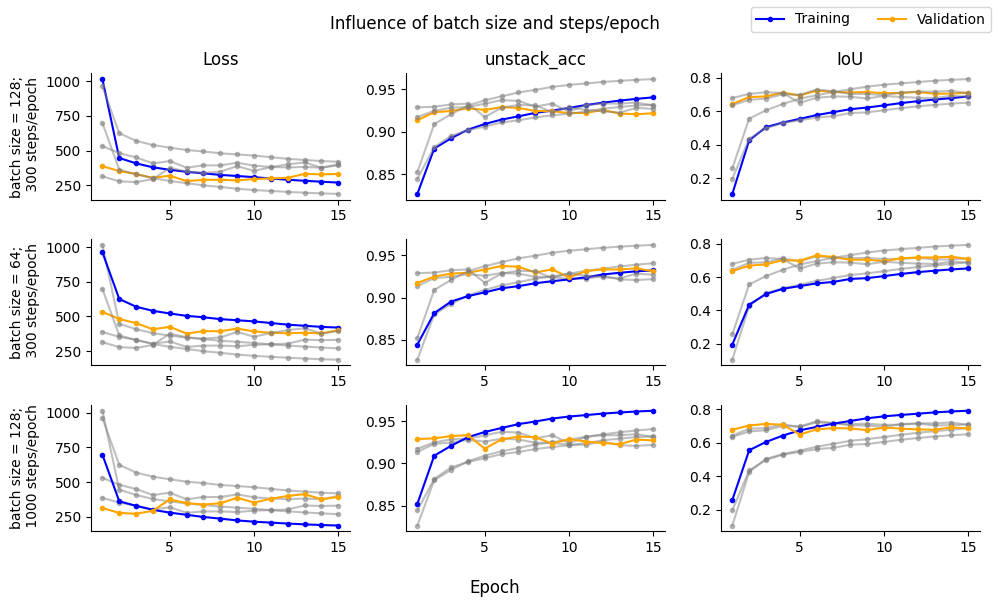

In [ ]:
with open("/content/gdrive/MyDrive/IBEC/Training_results/43rd training/history_fold_4.pkl", "rb") as file:
    history_1 = pickle.load(file)
with open("/content/gdrive/MyDrive/IBEC/Training_results/44th training/history_fold_4.pkl", "rb") as file:
    history_2 = pickle.load(file)
with open("/content/gdrive/MyDrive/IBEC/Training_results/45th training/history_fold_4.pkl", "rb") as file:
    history_3 = pickle.load(file)

history = {1: history_1, 2: history_2, 3: history_3}

fig, axs = plt.subplots(3, 3, figsize=(10,6))

for ax in np.ravel(axs):
    ax.spines[['right', 'top']].set_visible(False)

for i in range(3):
    plt.subplot(3, 3, 3*i+1)
    for j in range(1,4):
        if j != i+1:
            plt.plot(range(1,16), history[j]["loss"], color="gray", marker=".", alpha=0.5)
            plt.plot(range(1,16), history[j]["val_loss"], color="gray", marker=".", alpha=0.5)
        else:
            plt.plot(range(1,16), history[j]["loss"], color="blue", marker=".")
            plt.plot(range(1,16), history[j]["val_loss"], color="orange", marker=".")

    if i == 0:
        plt.ylabel("batch size = 128;\n 300 steps/epoch")
    if i == 1:
        plt.ylabel("batch size = 64;\n 300 steps/epoch")
    if i == 2:
        plt.ylabel("batch size = 128;\n 1000 steps/epoch")


    if i == 0:
      plt.title("Loss")

    plt.subplot(3, 3, 3*i+2)
    for j in range(1,4):
        if j != i+1:
            plt.plot(range(1,16), history[j]["unstack_acc"], color="gray", marker=".", alpha=0.5)
            plt.plot(range(1,16), history[j]["val_unstack_acc"], color="gray", marker=".", alpha=0.5)
        else:
            plt.plot(range(1,16), history[j]["unstack_acc"], color="blue", marker=".")
            plt.plot(range(1,16), history[j]["val_unstack_acc"], color="orange", marker=".")

    if i == 0:
      plt.title("unstack_acc")

    plt.subplot(3, 3, 3*i+3)
    for j in range(1,4):
        if j != i+1:
            plt.plot(range(1,16), history[j]["iou_metric"], color="gray", marker=".", alpha=0.5)
            plt.plot(range(1,16), history[j]["val_iou_metric"], color="gray", marker=".", alpha=0.5)
        elif i==0:
            plt.plot(range(1,16), history[j]["iou_metric"], color="blue", marker=".", label="Training")
            plt.plot(range(1,16), history[j]["val_iou_metric"], color="orange", marker=".", label="Validation")
        else:
            plt.plot(range(1,16), history[j]["iou_metric"], color="blue", marker=".")
            plt.plot(range(1,16), history[j]["val_iou_metric"], color="orange", marker=".")

    if i == 0:
      plt.title("IoU")

fig.supxlabel("Epoch")
plt.suptitle("Influence of batch size and steps/epoch")
fig.legend(ncol=2)
plt.tight_layout()

plt.savefig("/content/gdrive/MyDrive/IBEC/Training_results/45th training/43_vs_44_vs_45.png", dpi=600)

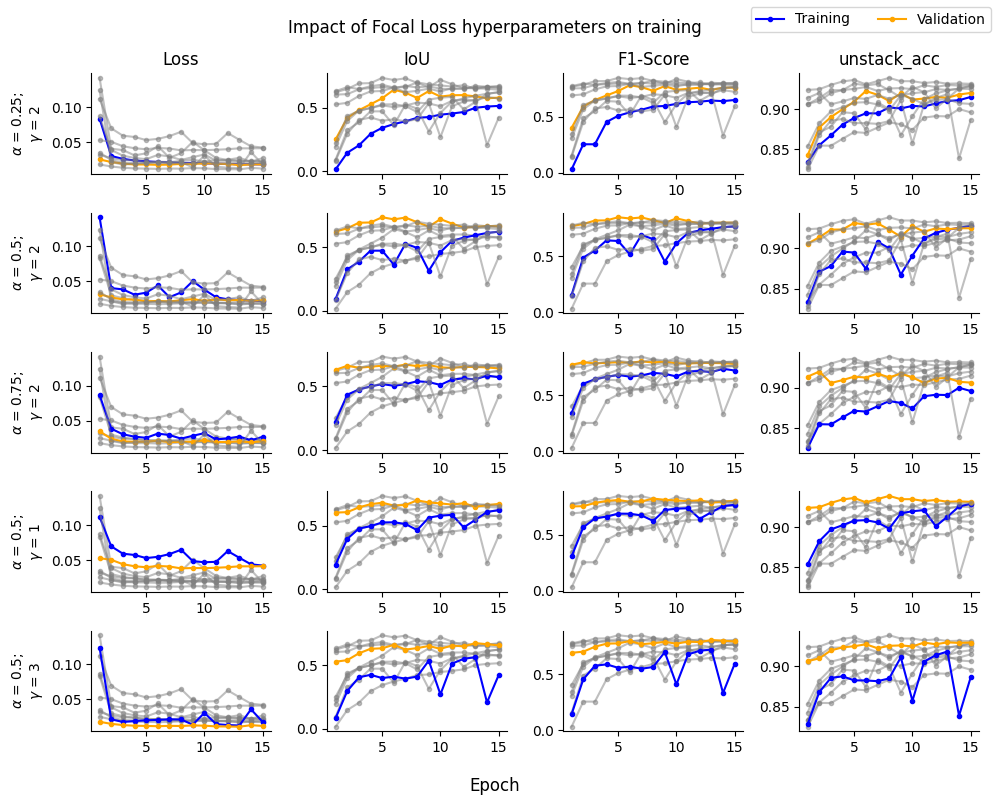

In [ ]:
with open("/content/gdrive/MyDrive/IBEC/Training_results/48th training/alpha0.25_gamma2_history_fold_4.pkl", "rb") as file:
    history1 = pickle.load(file)
with open("/content/gdrive/MyDrive/IBEC/Training_results/48th training/alpha0.5_gamma2_history_fold_4.pkl", "rb") as file:
    history2 = pickle.load(file)
with open("/content/gdrive/MyDrive/IBEC/Training_results/48th training/alpha0.75_gamma2_history_fold_4.pkl", "rb") as file:
    history3 = pickle.load(file)
with open("/content/gdrive/MyDrive/IBEC/Training_results/48th training/alpha0.5_gamma1_history_fold_4.pkl", "rb") as file:
    history4 = pickle.load(file)
with open("/content/gdrive/MyDrive/IBEC/Training_results/48th training/alpha0.5_gamma3_history_fold_4.pkl", "rb") as file:
    history5 = pickle.load(file)

history = {1: history1, 2: history2, 3: history3, 4: history4, 5: history5}

fig, axs = plt.subplots(5, 4, figsize=(10,8))

for ax in np.ravel(axs):
    ax.spines[['right', 'top']].set_visible(False)

for i in range(5):
    plt.subplot(5, 4, 4*i+1)
    if i == 0:
        plt.ylabel(r"$\alpha$ = 0.25;" "\n" r"$\gamma$ = 2")
        plt.title("Loss")
    if i == 1:
        plt.ylabel(r"$\alpha$ = 0.5;" "\n" r"$\gamma$ = 2")
    if i == 2:
        plt.ylabel(r"$\alpha$ = 0.75;" "\n" r"$\gamma$ = 2")
    if i == 3:
        plt.ylabel(r"$\alpha$ = 0.5;" "\n" r"$\gamma$ = 1")
    if i == 4:
        plt.ylabel(r"$\alpha$ = 0.5;" "\n" r"$\gamma$ = 3")

    for j in range(1,6):
        if j != i+1:
            plt.plot(range(1,16), history[j]["loss"], color="gray", marker=".", alpha=0.5)
            plt.plot(range(1,16), history[j]["val_loss"], color="gray", marker=".", alpha=0.5)
        else:
            plt.plot(range(1,16), history[j]["loss"], color="blue", marker=".")
            plt.plot(range(1,16), history[j]["val_loss"], color="orange", marker=".")

    plt.subplot(5, 4, 4*i+2)
    if i == 0:
        plt.title("IoU")

    for j in range(1,6):
        if j != i+1:
            plt.plot(range(1,16), history[j]["iou_metric"], color="gray", marker=".", alpha=0.5)
            plt.plot(range(1,16), history[j]["val_iou_metric"], color="gray", marker=".", alpha=0.5)
        else:
            plt.plot(range(1,16), history[j]["iou_metric"], color="blue", marker=".")
            plt.plot(range(1,16), history[j]["val_iou_metric"], color="orange", marker=".")

    plt.subplot(5, 4, 4*i+3)
    if i == 0:
        plt.title("F1-Score")

    for j in range(1,6):
        if j != i+1:
            plt.plot(range(1,16), history[j]["f1_metric"], color="gray", marker=".", alpha=0.5)
            plt.plot(range(1,16), history[j]["val_f1_metric"], color="gray", marker=".", alpha=0.5)
        else:
            plt.plot(range(1,16), history[j]["f1_metric"], color="blue", marker=".")
            plt.plot(range(1,16), history[j]["val_f1_metric"], color="orange", marker=".")

    plt.subplot(5, 4, 4*i+4)
    if i == 0:
        plt.title("unstack_acc")

    for j in range(1,6):
        if j != i+1:
            plt.plot(range(1,16), history[j]["unstack_acc"], color="gray", marker=".", alpha=0.5)
            plt.plot(range(1,16), history[j]["val_unstack_acc"], color="gray", marker=".", alpha=0.5)
        elif i == 0:
            plt.plot(range(1,16), history[j]["unstack_acc"], color="blue", marker=".", label="Training")
            plt.plot(range(1,16), history[j]["val_unstack_acc"], color="orange", marker=".", label="Validation")
        else:
            plt.plot(range(1,16), history[j]["unstack_acc"], color="blue", marker=".")
            plt.plot(range(1,16), history[j]["val_unstack_acc"], color="orange", marker=".")


fig.supxlabel("Epoch")
plt.suptitle("Impact of Focal Loss hyperparameters on training")
fig.legend(ncol=2)
plt.tight_layout()

plt.savefig("/content/gdrive/MyDrive/IBEC/Training_results/48th training/Focal_loss.png", dpi=600)

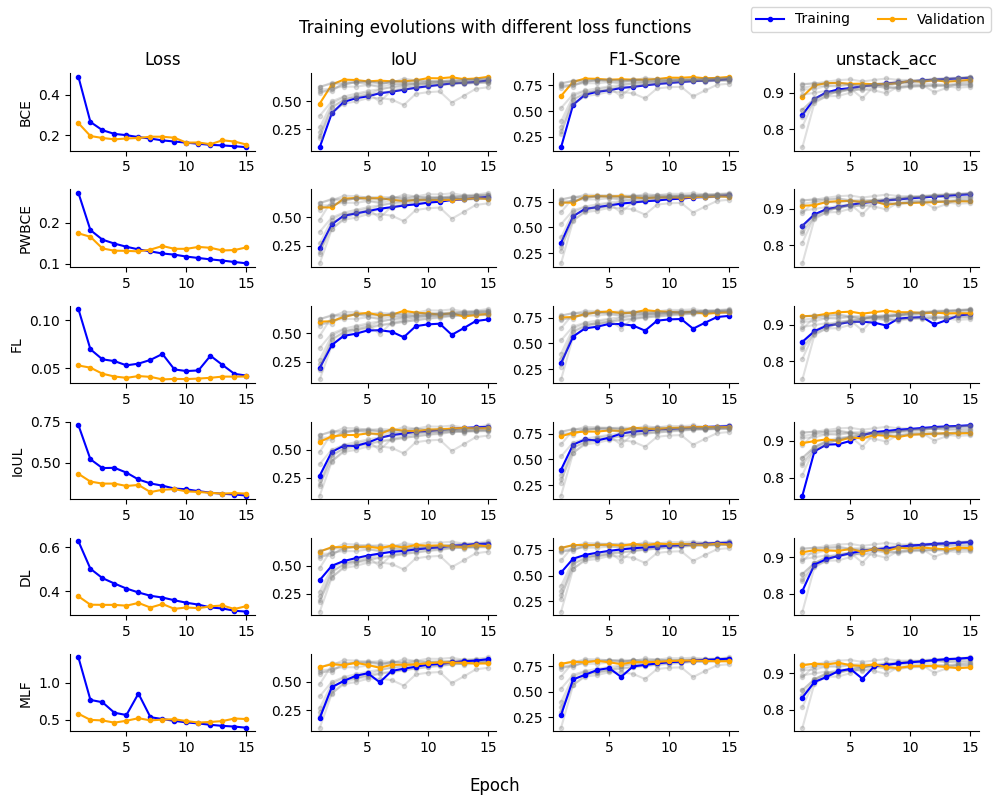

In [ ]:
with open("/content/gdrive/MyDrive/IBEC/Training_results/46th training/history_fold_4.pkl", "rb") as file:
    history1 = pickle.load(file)
with open("/content/gdrive/MyDrive/IBEC/Training_results/47th training/history_fold_4.pkl", "rb") as file:
    history2 = pickle.load(file)
with open("/content/gdrive/MyDrive/IBEC/Training_results/48th training/alpha0.5_gamma1_history_fold_4.pkl", "rb") as file:
    history3 = pickle.load(file)
with open("/content/gdrive/MyDrive/IBEC/Training_results/49th training/history_fold_4.pkl", "rb") as file:
    history4 = pickle.load(file)
with open("/content/gdrive/MyDrive/IBEC/Training_results/50th training/history_fold_4.pkl", "rb") as file:
    history5 = pickle.load(file)
with open("/content/gdrive/MyDrive/IBEC/Training_results/51st training/history_fold_4.pkl", "rb") as file:
    history6 = pickle.load(file)

history = {1: history1, 2: history2, 3: history3, 4: history4, 5: history5, 6: history6}

fig, axs = plt.subplots(6, 4, figsize=(10,8))

for ax in np.ravel(axs):
    ax.spines[['right', 'top']].set_visible(False)

for i in range(6):
    plt.subplot(6, 4, 4*i+1)
    if i == 0:
        plt.ylabel("BCE")
        plt.title("Loss")
    if i == 1:
        plt.ylabel("PWBCE")
    if i == 2:
        plt.ylabel("FL")
    if i == 3:
        plt.ylabel("IoUL")
    if i == 4:
        plt.ylabel("DL")
    if i == 5:
      plt.ylabel("MLF")

    for j in range(1,7):
        if j != i+1:
            pass
        else:
            plt.plot(range(1,16), history[j]["loss"], color="blue", marker=".")
            plt.plot(range(1,16), history[j]["val_loss"], color="orange", marker=".")

    plt.subplot(6, 4, 4*i+2)
    if i == 0:
        plt.title("IoU")

    for j in range(1,7):
        if j != i+1:
            plt.plot(range(1,16), history[j]["iou_metric"], color="gray", marker=".", alpha=0.25)
            plt.plot(range(1,16), history[j]["val_iou_metric"], color="gray", marker=".", alpha=0.25)
        else:
            plt.plot(range(1,16), history[j]["iou_metric"], color="blue", marker=".")
            plt.plot(range(1,16), history[j]["val_iou_metric"], color="orange", marker=".")

    plt.subplot(6, 4, 4*i+3)
    if i == 0:
        plt.title("F1-Score")

    for j in range(1,7):
        if j != i+1:
            plt.plot(range(1,16), history[j]["f1_metric"], color="gray", marker=".", alpha=0.25)
            plt.plot(range(1,16), history[j]["val_f1_metric"], color="gray", marker=".", alpha=0.25)
        else:
            plt.plot(range(1,16), history[j]["f1_metric"], color="blue", marker=".")
            plt.plot(range(1,16), history[j]["val_f1_metric"], color="orange", marker=".")

    plt.subplot(6, 4, 4*i+4)
    if i == 0:
        plt.title("unstack_acc")

    for j in range(1,7):
        if j != i+1:
            plt.plot(range(1,16), history[j]["unstack_acc"], color="gray", marker=".", alpha=0.25)
            plt.plot(range(1,16), history[j]["val_unstack_acc"], color="gray", marker=".", alpha=0.25)
        elif i == 0:
            plt.plot(range(1,16), history[j]["unstack_acc"], color="blue", marker=".", label="Training")
            plt.plot(range(1,16), history[j]["val_unstack_acc"], color="orange", marker=".", label="Validation")
        else:
            plt.plot(range(1,16), history[j]["unstack_acc"], color="blue", marker=".")
            plt.plot(range(1,16), history[j]["val_unstack_acc"], color="orange", marker=".")


fig.supxlabel("Epoch")
plt.suptitle("Training evolutions with different loss functions")
fig.legend(ncol=2)
plt.tight_layout()

plt.savefig("/content/gdrive/MyDrive/IBEC/Training_results/51st training/46_vs_47_vs_48_vs_49_vs_50_vs_51.png", dpi=600)

# Save model

In [ ]:
savefile = "/content/gdrive/MyDrive/IBEC/Models/38th training/trained.weights.h5"
model.save_weights(savefile)

# Segmentation

In [ ]:
# loadfile = "/content/gdrive/MyDrive/IBEC/Models/11th training/trained.weights.h5"
inputs_folder = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/No_val"
outputs_folder = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Masks_predicted/51st training"
inputs_files = sorted(os.listdir(inputs_folder))
print(len(inputs_files))

45


## Initialization of the net

In [ ]:
model = unet_rois(input_size=(64, 64, 1))
model.load_weights(loadfile)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Post process

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0

/content/gdrive/MyDrive/IBEC/data.py:138: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem = morph.square(square_size)


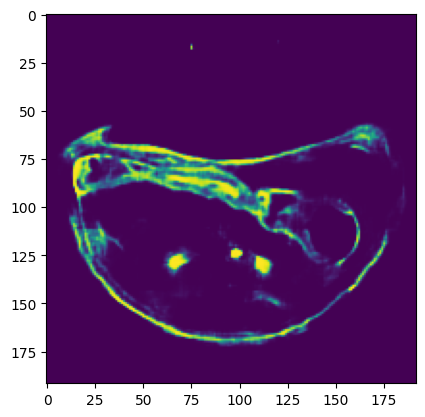

In [ ]:
# unprocessed = sorted(os.listdir(inputs_folder))
unprocessed = sorted(os.listdir(inputs_folder))

# Load up model:
model = unet_seg(input_size=cfg.target_size_seg+(1,),
                #  beta_1=0.85, beta_2=0.98,
                #  amsgrad=True, learning_rate=1e-5, loss="Dice",
                #  metrics=["BinaryIoU"]
                )
model.load_weights("/content/gdrive/MyDrive/IBEC/Models/51st training/unet_fold_4.weights.h5")

# Process
while(unprocessed):
    # Pop out filenames
    ps = min(4096,len(unprocessed)) #4096 at a time
    to_process = unprocessed[0:ps]
    del unprocessed[0:ps]

    # Predict:
    predGene = predictGenerator_seg(
                                    inputs_folder,
                                    files_list = to_process,
                                    target_size = cfg.target_size_seg,
                                    crop = cfg.crop_windows)
    # Use mother machine model
    if not cfg.crop_windows:
        results = model.predict(predGene,verbose=1)[:,:,:,0]
    # Use 2D surfaces model
    else:
        # Create array to store predictions
        img = readreshape(os.path.join(inputs_folder,to_process[0]),crop=True)
        # results = np.zeros((len(to_process),img.shape[0],img.shape[1],1))
        results = []
        # Crop, segment, stitch and store predictions in results
        for i in range(len(to_process)):
            # windows, loc_y, loc_x = utils.create_windows(next(predGene)[0,:,:], target_size=cfg.target_size_seg)
            windows, loc_y, loc_x = utils.create_windows(next(predGene)[0][0,:,:], target_size=cfg.target_size_seg)
            windows = windows[:,:,:,np.newaxis]
            pred = model.predict(windows,verbose=1,steps=windows.shape[0])

            pred = utils.stitch_pic(pred[:,:,:,0],loc_y,loc_x)[np.newaxis,:,:,np.newaxis]
            # results[i] = pred
            results.append(pred)

    # Post process results:
    results = postprocess(results, crop=cfg.crop_windows)

In [ ]:
# Save predictions
saveResult_seg(outputs_folder, results, files_list=inputs_files)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(192, 192)
(192, 192)
(192, 192)
(192, 192)
(192, 192)
(250, 250)
(128, 128)
(256, 256)
(256, 256)
(128, 130)
(120, 128)
(256, 256)
(120, 128)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(120, 128)
(256, 256)
(256, 256)
(128, 128)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(128, 128)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(192, 192)
(192, 192)
(192, 192)
(192, 192)
(192, 192)
(192, 192)


# Analyse results

In [ ]:
img_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/No_val"
validation_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Validation"
mask_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Masks"
mask_predicted_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Masks_predicted/51st training"
original = os.listdir(img_path) \
# + os.listdir(validation_path)
mask_real = os.listdir(mask_path)
segmented = os.listdir(mask_predicted_path)

In [ ]:
# for img in segmented:
#   if img in original:
#      shutil.copy(outputs_folder + "/" + img, mask_predicted_path)
#      print(img)

In [ ]:
# IoU metric for evaluating predictions
def IoU(X, Y):
  """
  X: real
  Y: predicted
  """
  intersection = np.logical_and(X, Y)
  union = np.logical_or(X, Y)
  iou = np.sum(intersection) / np.sum(union)
  return iou

## Plot results

In [ ]:
mask_predicted = os.listdir(mask_predicted_path)
original = os.listdir(img_path) \
#+ os.listdir(validation_path)
mask_real = os.listdir(mask_path)
save_path = "/content/gdrive/MyDrive/IBEC/Results/51st training"

IoUs = []
for i, img in enumerate(original):
  fig = plt.figure(figsize=(10, 5))
  plt.subplot(1, 3, 1)
  # Import and show original images
  try:
    plt.imshow(io.imread(img_path + "/" + img), cmap="gray")
  except:
    plt.imshow(io.imread(validation_path + "/" + img), cmap="gray")
  plt.title("Original image")
  plt.axis("off")
  plt.subplot(1, 3, 2)
  # Import and show real mask
  real = ski.color.rgb2gray(io.imread(mask_path + "/" + img)[:,:,:3])
  plt.imshow(real, cmap="gray")
  plt.title("Ground Truth")
  plt.axis("off")
  plt.subplot(1, 3, 3)
  # Import and show predicted mask
  predicted = io.imread(mask_predicted_path + "/" + img)
  plt.imshow(io.imread(mask_predicted_path + "/" + img), cmap="gray")
  plt.title("U-Net prediction")
  plt.axis("off")

  # Calculate IoU
  try:
    iou = IoU(real, predicted)
  except:
    iou = np.nan
  IoUs.append(iou)

  plt.suptitle(f"Image: {i+1}. IoU = {iou}")
  plt.tight_layout()
  plt.savefig(save_path + f"/{i+1}.png")

fig = plt.figure()
plt.plot(np.arange(1, len(IoUs)+1, 1), IoUs)
plt.grid()
plt.title("IoU of each image")
plt.xlabel("Image")
plt.ylabel("IoU")
plt.savefig(save_path + "/IoU.png")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Mean IoU
np.nanmean(IoUs)

0.6726279532015541

# Final Results

## Evaluation metrics

In [ ]:
def IoU(X, Y):
  """
  X: real
  Y: predicted
  """
  intersection = np.logical_and(X, Y)
  union = np.logical_or(X, Y)
  iou = np.sum(intersection) / np.sum(union)
  return iou

In [ ]:
def calc_confusion_matrix(X, Y):
    X = X.flatten().astype(int)
    Y = Y.flatten().astype(int)/255
    cm = confusion_matrix(X, Y) / len(X) * 100
    TN, FP, FN, TP = cm.ravel()

    return TN, FP, FN, TP

In [ ]:
def win_rate(series, thres):
    series = np.array(series)
    n = len(series)
    return np.sum(series >= thres) / n * 100

In [ ]:
input_images_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/No_val/"
mask_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Masks/"
training_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Original/"
validation_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Validation/"
mask_predicted_path = "/content/gdrive/MyDrive/IBEC/Images/Train_fat/Masks_predicted/45th training/"

input_images = os.listdir(input_images_path)
real_masks = os.listdir(mask_path)
predicted_masks = os.listdir(mask_predicted_path)
training_images = os.listdir(training_path)
validation_images = os.listdir(validation_path)

## Calulate metrics

In [ ]:
IoUs = []
training_IoUs = []
validation_IoUs = []
TPs = []
training_TPs = []
validation_TPs = []
FPs = []
training_FPs = []
validation_FPs = []
FNs = []
training_FNs = []
validation_FNs = []
TNs = []
training_TNs = []
validation_TNs = []
for img in input_images:
    # Load images
    ld_image = io.imread(input_images_path + img)
    ld_mask = ski.color.rgb2gray(io.imread(mask_path + img)[:,:,:3])
    ld_predicted = io.imread(mask_predicted_path + img)

    # Calculate IoU
    iou = IoU(ld_mask, ld_predicted)
    IoUs += [iou]

    # Calculate confusion matrix
    TN, FP, FN, TP = calc_confusion_matrix(ld_mask, ld_predicted)
    TPs += [TP]
    FPs += [FP]
    FNs += [FN]
    TNs += [TN]

    # Add to training or validation IoU
    if img in training_images:
        training_IoUs += [iou]
        training_TPs += [TP]
        training_FPs += [FP]
        training_FNs += [FN]
        training_TNs += [TN]
    else:
        validation_IoUs += [iou]
        validation_TPs += [TP]
        validation_FPs += [FP]
        validation_FNs += [FN]
        validation_TNs += [TN]

In [ ]:
total_win_rate = win_rate(IoUs, 0.6)
training_win_rate = win_rate(training_IoUs, 0.6)
validation_win_rate = win_rate(validation_IoUs, 0.6)

## IoU distribution

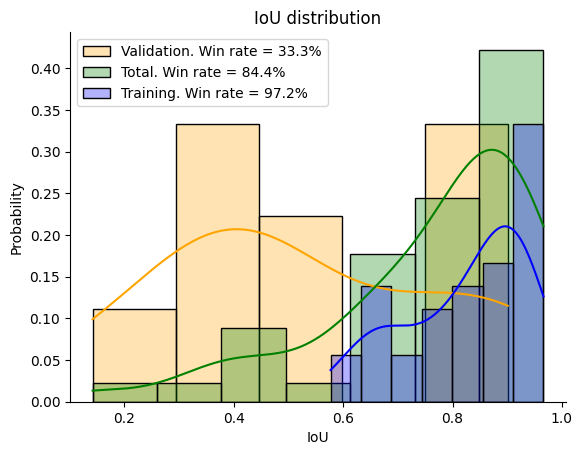

In [ ]:
fig, ax = plt.subplots()
ax.spines[['right', 'top']].set_visible(False)

sns.histplot(validation_IoUs, kde=True, stat="probability", alpha=0.3, color="orange",
             label=f"Validation. Win rate = {validation_win_rate:.1f}%")
sns.histplot(IoUs, kde=True, stat="probability", alpha=0.3, color="green",
             label=f"Total. Win rate = {total_win_rate:.1f}%")
sns.histplot(training_IoUs, kde=True, stat="probability", alpha=0.3, color="blue",
             label=f"Training. Win rate = {training_win_rate:.1f}%")
plt.legend()
plt.xlabel("IoU")
plt.title("IoU distribution")

fig.savefig("/content/gdrive/MyDrive/IBEC/Results/45th training/IoU_dist.png", dpi=600)

## Histogram of confusion matrix

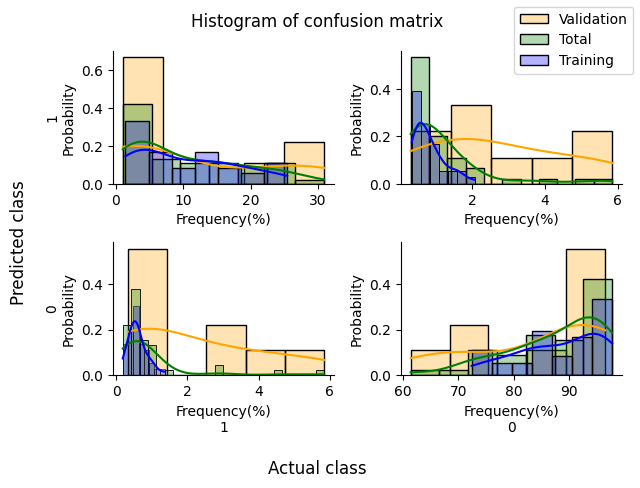

In [ ]:
fig, axs = plt.subplots(2, 2)
for ax in axs.ravel():
    ax.spines[['right', 'top']].set_visible(False)

plt.subplot(2, 2, 1)
sns.histplot(validation_TPs, kde=True, stat="probability", alpha=0.3, color="orange",
             label=f"Validation")
sns.histplot(TPs, kde=True, stat="probability", alpha=0.3, color="green",
             label=f"Total")
sns.histplot(training_TPs, kde=True, stat="probability", alpha=0.3, color="blue",
             label=f"Training")
plt.ylabel("1\nProbability")
plt.xlabel("Frequency(%)")

plt.subplot(2, 2, 2)
sns.histplot(validation_FPs, kde=True, stat="probability", alpha=0.3, color="orange")
sns.histplot(FPs, kde=True, stat="probability", alpha=0.3, color="green")
sns.histplot(training_FPs, kde=True, stat="probability", alpha=0.3, color="blue")
plt.ylabel("Probability")
plt.xlabel("Frequency(%)")

plt.subplot(2, 2, 3)
sns.histplot(validation_FNs, kde=True, stat="probability", alpha=0.3, color="orange")
sns.histplot(FNs, kde=True, stat="probability", alpha=0.3, color="green")
sns.histplot(training_FNs, kde=True, stat="probability", alpha=0.3, color="blue")
plt.ylabel("0\nProbability")
plt.xlabel("Frequency(%)\n1")

plt.subplot(2, 2, 4)
sns.histplot(validation_TNs, kde=True, stat="probability", alpha=0.3, color="orange")
sns.histplot(TNs, kde=True, stat="probability", alpha=0.3, color="green")
sns.histplot(training_TNs, kde=True, stat="probability", alpha=0.3, color="blue")
plt.ylabel("Probability")
plt.xlabel("Frequency(%)\n0")

fig.supxlabel("Actual class")
fig.supylabel("Predicted class")
plt.suptitle("Histogram of confusion matrix")
fig.legend(ncols=1)
plt.tight_layout()

fig.savefig("/content/gdrive/MyDrive/IBEC/Results/45th training/hist_confusion_matrix.png", dpi=600)

## Mean confusion matrix

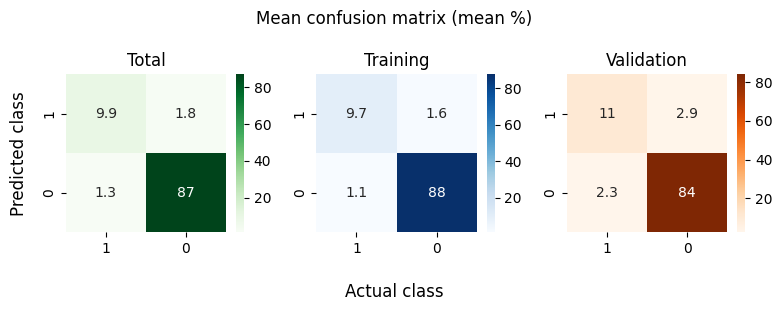

In [ ]:
cm = np.array([[np.mean(TPs), np.mean(FPs)],
               [np.mean(FNs), np.mean(TNs)]])
validation_cm = np.array([[np.mean(validation_TPs), np.mean(validation_FPs)],
                           [np.mean(validation_FNs), np.mean(validation_TNs)]])
training_cm = np.array([[np.mean(training_TPs), np.mean(training_FPs)],
                        [np.mean(training_FNs), np.mean(training_TNs)]])

fig, axs = plt.subplots(1, 3, figsize=(8, 3))
for ax in axs.ravel():
    ax.spines[['right', 'top']].set_visible(False)

plt.subplot(1, 3, 1)
ax = sns.heatmap(cm[::-1, ::-1], annot=True, cmap="Greens")
ax.invert_yaxis()
ax.invert_xaxis()
plt.title("Total")

plt.subplot(1, 3, 2)
ax = sns.heatmap(training_cm[::-1, ::-1], annot=True, cmap="Blues")
ax.invert_yaxis()
ax.invert_xaxis()
plt.title("Training")

plt.subplot(1, 3, 3)
ax = sns.heatmap(validation_cm[::-1, ::-1], annot=True, cmap="Oranges")
ax.invert_yaxis()
ax.invert_xaxis()
plt.title("Validation")

fig.supxlabel("Actual class")
fig.supylabel("Predicted class")
plt.suptitle("Mean confusion matrix (mean %)")
plt.tight_layout()

fig.savefig("/content/gdrive/MyDrive/IBEC/Results/51st training/mean_confusion_matrix.png", dpi=600)

# Validation (unseen)

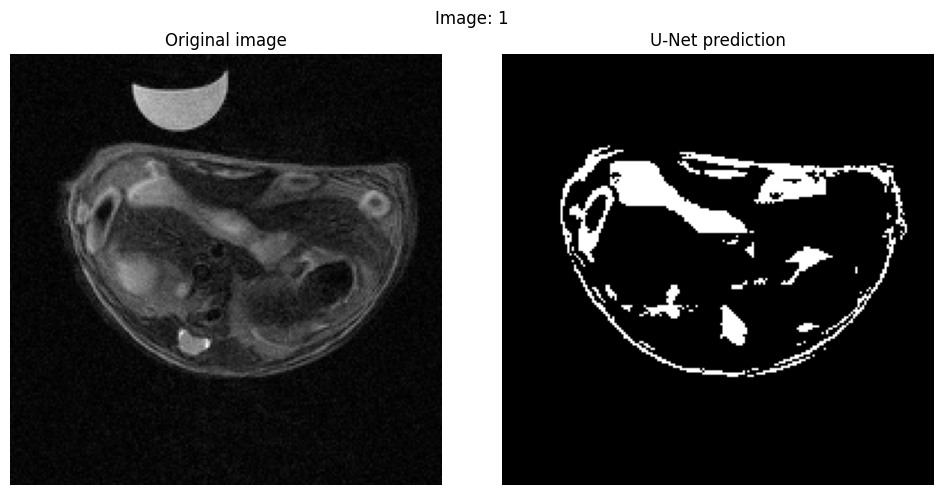

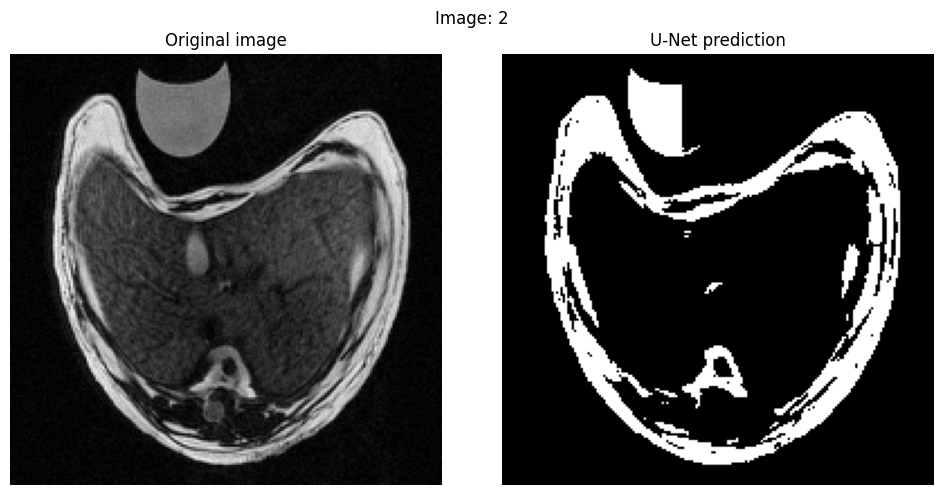

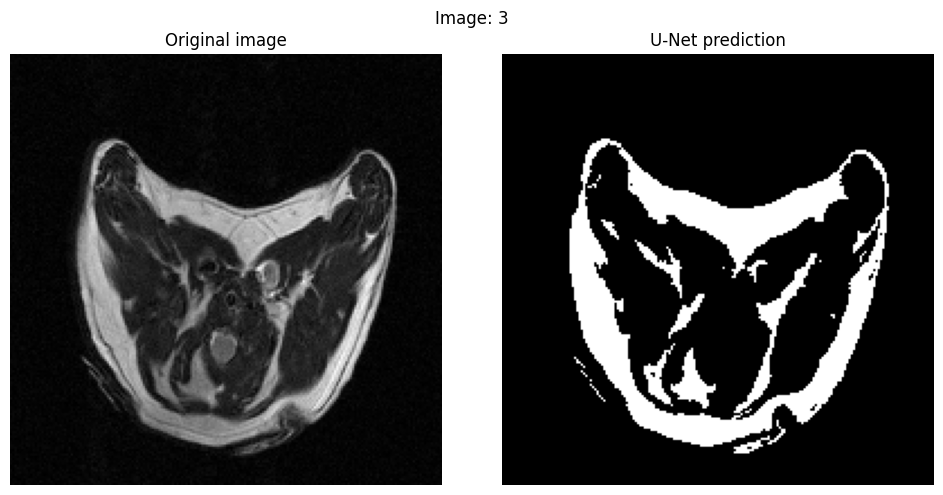

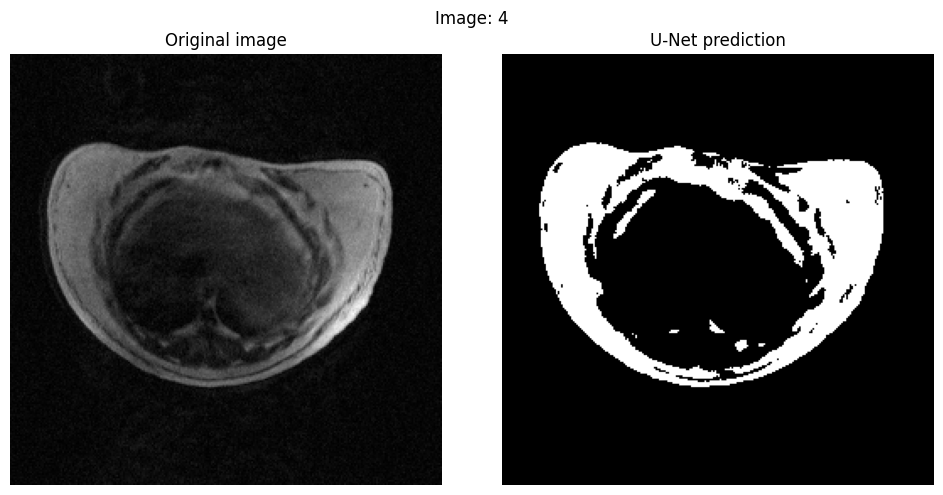

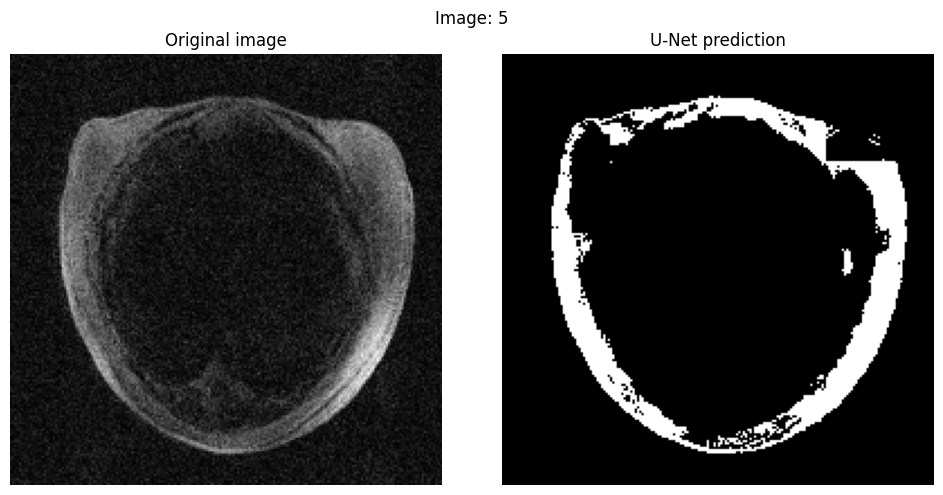

In [ ]:
mask_predicted = os.listdir(mask_predicted_path)
original = os.listdir(img_path) \
#+ os.listdir(validation_path)
mask_real = os.listdir(mask_path)

for i, img in enumerate(original):
  fig = plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  try:
    plt.imshow(io.imread(img_path + "/" + img), cmap="gray")
  except:
    plt.imshow(io.imread(validation_path + "/" + img), cmap="gray")
  plt.title("Original image")
  plt.axis("off")
  plt.subplot(1, 2, 2)
  predicted = io.imread(mask_predicted_path + "/" + img)
  plt.imshow(io.imread(mask_predicted_path + "/" + img), cmap="gray")
  plt.title("U-Net prediction")
  plt.axis("off")

  plt.suptitle(f"Image: {i+1}")
  plt.tight_layout()